# Product recommendataion

Ref: https://jessesw.com/Rec-System/\
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Articles%20Rec%20System%20Implicit.ipynb\
https://nbviewer.jupyter.org/github/jmsteinw/Notebooks/blob/master/RecEngine_NB.ipynb\

TODO:
Evaluatate https://making.lyst.com/lightfm/docs/index.html

### Load libraries

In [1]:
import random
import implicit

import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

### Load data

In [2]:
# This may take a couple minutes
retail_data = pd.read_csv('data.csv',
                         parse_dates=['InvoiceDate'])

In [3]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<AxesSubplot:>

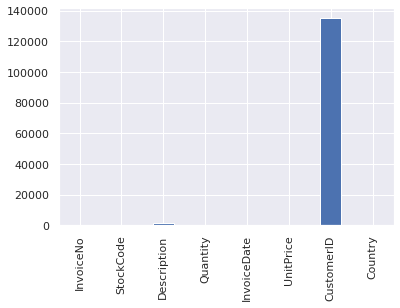

In [5]:
retail_data.isnull().sum().plot(kind='bar')

In [6]:
cleaned_retail = retail_data.dropna(subset=['CustomerID'])

In [7]:
# Convert to int for customer ID
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int).astype(str)

# Get rid of unnecessary info
cleaned_retail = cleaned_retail[['StockCode','Description', 'Quantity', 'CustomerID']]

# Group together
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode','Description']).sum().reset_index()

# Replace a sum of zero purchases with a one to
#grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1

# indicate purchased
grouped_df = grouped_cleaned.loc[grouped_cleaned['Quantity'] > 0]
# Only get customers where purchase totals were positive

## Calculate Implicit ratings from purchase quantity

In [8]:
grouped_df['maxQuantity'] = grouped_df.groupby(['CustomerID'])['Quantity'].transform(max)
grouped_df['implicit_rating'] = grouped_df.apply(lambda x: 10 * x.Quantity / x.maxQuantity, axis=1)
grouped_df.head()

,CustomerID,StockCode,Description,Quantity,maxQuantity,implicit_rating
1,12347,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,240,1.000000
2,12347,17021,NAMASTE SWAGAT INCENSE,36,240,1.500000
3,12347,20665,RED RETROSPOT PURSE,6,240,0.250000
4,12347,20719,WOODLAND CHARLOTTE BAG,40,240,1.666667
5,12347,20780,BLACK EAR MUFF HEADPHONES,12,240,0.500000


In [9]:
grouped_df[grouped_df['CustomerID']=='12347'].sort_values(by=['implicit_rating'], ascending=False)

,CustomerID,StockCode,Description,Quantity,maxQuantity,implicit_rating
59,12347,23076,ICE CREAM SUNDAE LIP GLOSS,240,240,10.000000
89,12347,84558A,3D DOG PICTURE PLAYING CARDS,126,240,5.250000
36,12347,22492,MINI PAINT SET VINTAGE,108,240,4.500000
60,12347,23084,RABBIT NIGHT LIGHT,84,240,3.500000
95,12347,84991,60 TEATIME FAIRY CAKE CASES,72,240,3.000000
...,...,...,...,...,...,...
35,12347,22432,WATERING CAN PINK BUNNY,6,240,0.250000
6,12347,20782,CAMOUFLAGE EAR MUFF HEADPHONES,6,240,0.250000
67,12347,23173,REGENCY TEAPOT ROSES,4,240,0.166667
68,12347,23174,REGENCY SUGAR BOWL GREEN,4,240,0.166667


In [10]:
grouped_df['CustomerID'] = grouped_df['CustomerID'].astype("category")
grouped_df['StockCode'] = grouped_df['StockCode'].astype("category")

grouped_df['CustomerID_idx'] = grouped_df['CustomerID'].cat.codes
grouped_df['StockCode_idx'] = grouped_df['StockCode'].cat.codes

In [11]:
# Get our unique customers
customers = list(np.sort(grouped_df.CustomerID.unique()))

# Get our unique products that were purchased
products = list(grouped_df.StockCode.unique())

# All of our purchases
quantity = list(grouped_df.Quantity)

# Get the associated row indices
rows = grouped_df['CustomerID_idx']

# Get the associated column indices
cols = grouped_df['StockCode_idx']

# create the sparse ratings matrix of users and items
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

In [12]:
purchases_sparse

<4326x3649 sparse matrix of type '<class 'numpy.int64'>'
	with 265237 stored elements in Compressed Sparse Row format>

In [13]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

98.31975067868929

98.3% of the interaction matrix is sparse. For collaborative filtering to work, the maximum sparsity you could get away with would probably be about 99.5% or so. We are well below this, so we should be able to get decent results.

## Using ALS Implicit model

In [14]:
sparse_content_person = sparse.csr_matrix(
    (grouped_df['implicit_rating'].astype(float), (grouped_df['StockCode_idx'], grouped_df['CustomerID_idx']))
)


sparse_person_content = sparse.csr_matrix(
    (grouped_df['implicit_rating'].astype(float), (grouped_df['CustomerID_idx'], grouped_df['StockCode_idx']))
)

In [15]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

In [16]:
alpha = 15
data = (sparse_content_person * alpha).astype('double')

# Fit the model
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
content_id = 1
n_similar = 10

person_vecs = model.user_factors
content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

scores = content_vecs.dot(content_vecs[content_id]) / content_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

In [18]:
for content in similar:
    idx, score = content
    print(grouped_df.Description.loc[grouped_df.StockCode_idx == idx].iloc[0])

GROOVY CACTUS INFLATABLE
TOOTHPASTE TUBE PEN
KITTY PENCIL ERASERS
RETRO PLASTIC POLKA TRAY
SKULLS SQUARE TISSUE BOX
HOUSE SHAPE PENCIL SHARPENER
MAGIC SHEEP WOOL GROWING FROM PAPER
ORANGE TV TRAY TABLE 
RED FLOCK LOVE HEART PHOTO FRAME
MAGNETS PACK OF 4 RETRO PHOTO


In [19]:
grouped_df[grouped_df['StockCode_idx']==1]

,CustomerID,StockCode,Description,Quantity,maxQuantity,implicit_rating,CustomerID_idx,StockCode_idx
35730,13091,10080,GROOVY CACTUS INFLATABLE,24,48,5.000000,560,1
61670,13717,10080,GROOVY CACTUS INFLATABLE,12,240,0.500000,1009,1
82499,14189,10080,GROOVY CACTUS INFLATABLE,12,144,0.833333,1350,1
88517,14321,10080,GROOVY CACTUS INFLATABLE,12,100,1.200000,1444,1
100018,14535,10080,GROOVY CACTUS INFLATABLE,1,100,0.100000,1604,1
118576,14904,10080,GROOVY CACTUS INFLATABLE,12,336,0.357143,1867,1
131814,15150,10080,GROOVY CACTUS INFLATABLE,12,50,2.400000,2049,1
133992,15203,10080,GROOVY CACTUS INFLATABLE,12,60,2.000000,2085,1
137309,15298,10080,GROOVY CACTUS INFLATABLE,24,144,1.666667,2160,1
148915,15547,10080,GROOVY CACTUS INFLATABLE,2,480,0.041667,2344,1


In [20]:
def recommend(user_id_idx, sparse_person_content, person_vecs, content_vecs, num_contents=12):
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_person_content[user_id_idx,:].toarray()
    
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1
    
    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0
    
    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[user_id_idx,:].dot(content_vecs.T).toarray()
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    user_id = grouped_df.CustomerID.loc[grouped_df.CustomerID_idx == user_id_idx].iloc[0]
    
    # Start empty list to store titles and scores
    descriptions = []
    scores = []
    product_ids = []
    user_ids=[]

    for idx in content_idx:
        # Append titles and scores to the list
        descriptions.append(grouped_df.Description.loc[grouped_df.StockCode_idx == idx].iloc[0])
        scores.append(recommend_vector[idx])
        product_ids.append(grouped_df.StockCode.loc[grouped_df.StockCode_idx == idx].iloc[0])
        user_ids.append(user_id)
        

    recommendations = pd.DataFrame({'user_id':user_ids, 'product_id':product_ids, 
                                    'Description': descriptions, 'score': scores})

    return recommendations

In [21]:
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)

## Evaluate the recommendataion

In [22]:
# Create recommendations for person with id 
person_id = 0
recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)

print(recommendations)

   user_id product_id                          Description     score
0    12347      84692          BOX OF 24 COCKTAIL PARASOLS  1.000000
1    12347      22197                       POPCORN HOLDER  0.895881
2    12347      21787                RAIN PONCHO RETROSPOT  0.894532
3    12347      23154             SET OF 4 JAM JAR MAGNETS  0.879296
4    12347      23159         SET OF 5 PANCAKE DAY MAGNETS  0.878503
5    12347      22924        FRIDGE MAGNETS LA VIE EN ROSE  0.865172
6    12347      23122               PARTY CHARMS 50 PIECES  0.852707
7    12347      23119        PACK OF 6 LARGE FRUIT STRAWS   0.849075
8    12347      23078             ICE CREAM PEN LIP GLOSS   0.848876
9    12347      22962                JAM JAR WITH PINK LID  0.839370
10   12347      84988   SET OF 72 PINK HEART PAPER DOILIES  0.836329
11   12347      23309  SET OF 60 I LOVE LONDON CAKE CASES   0.835786


In [23]:
grouped_df.loc[grouped_df['CustomerID_idx'] == 0].sort_values(
    by=['implicit_rating'], ascending=False)[
    ['StockCode', 'Description','CustomerID', 'Quantity', 'implicit_rating']
].head(10)

,StockCode,Description,CustomerID,Quantity,implicit_rating
59,23076,ICE CREAM SUNDAE LIP GLOSS,12347,240,10.00
89,84558A,3D DOG PICTURE PLAYING CARDS,12347,126,5.25
36,22492,MINI PAINT SET VINTAGE,12347,108,4.50
60,23084,RABBIT NIGHT LIGHT,12347,84,3.50
95,84991,60 TEATIME FAIRY CAKE CASES,12347,72,3.00
16,21731,RED TOADSTOOL LED NIGHT LIGHT,12347,72,3.00
24,22196,SMALL HEART MEASURING SPOONS,12347,72,3.00
96,84992,72 SWEETHEART FAIRY CAKE CASES,12347,72,3.00
73,23308,SET OF 60 VINTAGE LEAF CAKE CASES,12347,48,2.00
23,22195,LARGE HEART MEASURING SPOONS,12347,48,2.00


In [24]:
person_id = 2
recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)
recommendations

,user_id,product_id,Description,score
0,12349,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,1.000000
1,12349,22558,CLOTHES PEGS RETROSPOT PACK 24,0.974997
2,12349,22969,HOMEMADE JAM SCENTED CANDLES,0.964947
3,12349,22138,BAKING SET 9 PIECE RETROSPOT,0.957122
4,12349,22966,GINGERBREAD MAN COOKIE CUTTER,0.923250
5,12349,21212,PACK OF 72 RETROSPOT CAKE CASES,0.916030
6,12349,22961,JAM MAKING SET PRINTED,0.901404
7,12349,23245,SET OF 3 REGENCY CAKE TINS,0.890456
8,12349,22759,SET OF 3 NOTEBOOKS IN PARCEL,0.868115
9,12349,84378,SET OF 3 HEART COOKIE CUTTERS,0.861522


In [25]:
grouped_df.loc[grouped_df['CustomerID_idx'] == 2].sort_values(
    by=['implicit_rating'], ascending=False)[
    ['StockCode', 'Description','CustomerID', 'Quantity', 'implicit_rating']
].head(10)

,StockCode,Description,CustomerID,Quantity,implicit_rating
130,21231,SWEETHEART CERAMIC TRINKET BOX,12349,36,10.000000
131,21232,STRAWBERRY CERAMIC TRINKET POT,12349,36,10.000000
159,22704,WRAP RED APPLES,12349,25,6.944444
185,23545,WRAP RED VINTAGE DOILY,12349,25,6.944444
138,21787,RAIN PONCHO RETROSPOT,12349,24,6.666667
129,21136,PAINTED METAL PEARS ASSORTED,12349,16,4.444444
189,47504H,ENGLISH ROSE SPIRIT LEVEL,12349,12,3.333333
154,22557,PLASTERS IN TIN VINTAGE PAISLEY,12349,12,3.333333
151,22554,PLASTERS IN TIN WOODLAND ANIMALS,12349,12,3.333333
152,22555,PLASTERS IN TIN STRONGMAN,12349,12,3.333333


## Evaluating the Recommender system

In [26]:
def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of item,user index into list

    
    random.seed(0) # Set the random seed to zero for reproducibility
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    content_inds = [index[0] for index in samples] # Get the item row indices

    person_inds = [index[1] for index in samples] # Get the user column indices

    
    training_set[content_inds, person_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(person_inds))

In [27]:
content_train, content_test, content_persons_altered = make_train(sparse_content_person, pct_test = 0.2)

In [28]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [29]:
def calc_mean_auc(training_set, altered_persons, predictions, test_set):
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_contents = np.array(test_set.sum(axis = 1)).reshape(-1) # Get sum of item iteractions to find most popular
    content_vecs = predictions[1]
    
    for person in altered_persons: # Iterate through each user that had an item altered
        training_column = training_set[:,person].toarray().reshape(-1) # Get the training set column
        zero_inds = np.where(training_column == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        person_vec = predictions[0][person,:]
        pred = person_vec.dot(content_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,person].toarray()[zero_inds,0].reshape(-1)
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_contents[zero_inds] # Get the item popularity for our chosen items
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [30]:
calc_mean_auc(content_train, content_persons_altered,
              [person_vecs, content_vecs.T], content_test)

(0.928, 0.816)

In [31]:
data_you_need=pd.DataFrame()
user_ids = set(grouped_df['CustomerID_idx'].values.tolist())
for user_id in user_ids:
    recommendations = recommend(user_id, sparse_person_content, person_vecs, content_vecs)
    data_you_need=data_you_need.append(recommendations,ignore_index=True)

In [32]:
data_you_need["type"] = "implicit"
data_you_need["rating_timestamp"] = pd.Timestamp.now(tz='Asia/Bangkok')
data_you_need["rating"] = data_you_need["score"]

In [33]:
data_you_need.head(10)

,user_id,product_id,Description,score,type,rating_timestamp,rating
0,12347,84692,BOX OF 24 COCKTAIL PARASOLS,1.000000,implicit,2021-06-02 05:39:47.447227+07:00,1.000000
1,12347,22197,POPCORN HOLDER,0.895881,implicit,2021-06-02 05:39:47.447227+07:00,0.895881
2,12347,21787,RAIN PONCHO RETROSPOT,0.894532,implicit,2021-06-02 05:39:47.447227+07:00,0.894532
3,12347,23154,SET OF 4 JAM JAR MAGNETS,0.879296,implicit,2021-06-02 05:39:47.447227+07:00,0.879296
4,12347,23159,SET OF 5 PANCAKE DAY MAGNETS,0.878503,implicit,2021-06-02 05:39:47.447227+07:00,0.878503
5,12347,22924,FRIDGE MAGNETS LA VIE EN ROSE,0.865172,implicit,2021-06-02 05:39:47.447227+07:00,0.865172
6,12347,23122,PARTY CHARMS 50 PIECES,0.852707,implicit,2021-06-02 05:39:47.447227+07:00,0.852707
7,12347,23119,PACK OF 6 LARGE FRUIT STRAWS,0.849075,implicit,2021-06-02 05:39:47.447227+07:00,0.849075
8,12347,23078,ICE CREAM PEN LIP GLOSS,0.848876,implicit,2021-06-02 05:39:47.447227+07:00,0.848876
9,12347,22962,JAM JAR WITH PINK LID,0.839370,implicit,2021-06-02 05:39:47.447227+07:00,0.839370
